In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
import io

In [8]:
# Specify the URL of the data tile
url = (
    'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/'
    'Hansen_GFC-2019-v1.7_treecover2000_50N_090W.tif')
#50N, 90W canada


## Instructions

You have to specify the URL of the data tile you want to download.
The important part of the URL is the `00N_010E` part at the end.
This specifies the latitude and longitude (in 10-degree units)
of the data tile to download.

* [The list of all available data tile URLs is provided here.](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/treecover2000.txt)
* There is a nice visualization of the data tiles under "Download Instructions" in [the data source](http://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html). Use it to identify which data tile you want.
* There is also an [interactive map](http://earthenginepartners.appspot.com/science-2013-global-forest) that allows you to zoom in on any part of the data set. Select "2000 Percent Tree Cover" from the "Data Products" menu and then pan and zoom on the map. (It's beautiful!)

In [9]:
# Load the data into a NumPy array. It might take a minute to
# download the data since these data tiles are large.
Image.MAX_IMAGE_PIXELS = None
data_tile = np.array(
    Image.open(
        io.BytesIO(
            requests.get(url).content)))

In [10]:
# Each data tile is 40,000 x 40,000 and contains values from 0
# to 100, indicating the percentage tree cover in each grid cell.
data_tile.shape

(40000, 40000)

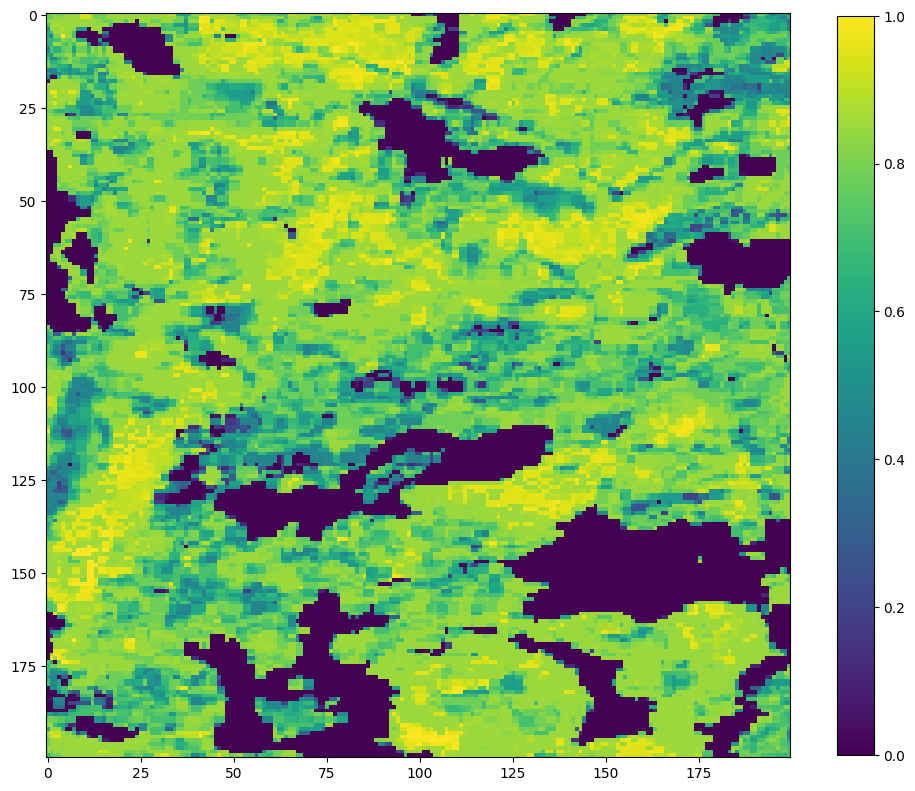

In [11]:
# Plot a 2000 x 2000 part of the whole data tile. You can plot all
# of it but it takes a long time since the data tile is so large.
section = data_tile[100:300, 0:200]
section_normalized = (section - section.min()) / (section.max() - section.min())

plt.figure(figsize=(12, 12))
plt.imshow(section_normalized, cmap='viridis')
plt.colorbar(shrink=0.8)
plt.show()

# Simulation code

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, Normalize
from IPython.display import HTML
from tqdm import tqdm

class ForestFireSimulation:
    def __init__(self, data, wind_direction, wind_strength):
        """
        Initializes the simulation with given data and wind settings.

        data: copy of the data downloaded from the map (values between 0 and 1).
        wind_direction: Tuple (dx, dy) indicating the wind direction.
        wind_strength: Float indicating the strength of the wind.

        """
        self.data = np.copy(data)
        self.wind_direction = wind_direction
        self.wind_strength = wind_strength
        self.fire_grid = np.zeros_like(data, dtype=int)  # 0 (normal trees), 1(burning), 2(charred)

    def setup_plot(self):
        """
        Sets up the plotting environment.
        """
        self.figure, self.ax = plt.subplots(figsize=(10, 10))
        cmap = ListedColormap(['green', 'red', 'black'])
        norm = Normalize(vmin=0, vmax=2)
        self.im = self.ax.imshow(self.fire_grid, cmap=cmap, norm=norm, interpolation='nearest')
        self.ax.set_title('Forest Fire Simulation (green=normal, red=burning, black=charred)')

    def spread_fire(self):
        """
        Spreads the fire based on current wind direction and strength.
        i,j = each cell's x and y
        dx,dy = wind direction relative to cell ij
        di,dj = neighboring cell's coordinate relative to cell ij
        ni,nj = neighboring cell's indexes in the map
        """
        new_fire_grid = np.copy(self.fire_grid)
        dx, dy = self.wind_direction
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                # if cell is on fire
                if self.fire_grid[i, j] == 1:
                    new_fire_grid[i, j] = 2  # Mark as charred since it will be charred
                    for di in range(-1, 2):
                        for dj in range(-1, 2):
                            ni, nj = i + di, j + dj
                            if 0 <= ni < self.data.shape[0] and 0 <= nj < self.data.shape[1]:
                                # make sure to not burn charred cells again
                                if self.fire_grid[ni, nj] != 2:
                                    #finding dot product help us find if the neighbor is in the direction of the wind.
                                    dot_product = np.dot((dx, dy), (di, dj)) #can take values: -2,-1,0,1,2.
                                    # sigmoid transformation to emphasize the effect of the wind alignment
                                    sigmoid_transformation = 1 / (1 + np.exp(-dot_product * self.wind_strength))
                                    base_probability = 0.3  # Lower base means higher impact of wind strenghth and direction.
                                    if self.data[ni, nj] != 0: #exclude for those cells that do not have trees from the start.
                                      spread_prob = self.data[ni, nj] * base_probability + sigmoid_transformation * (1 - base_probability)

                                      if np.random.random() < spread_prob:
                                          new_fire_grid[ni, nj] = 1

                elif self.fire_grid[i, j] == 2:
                    new_fire_grid[i, j] = 2  # charred cells stay charred

        self.fire_grid = new_fire_grid #update synchronously

    def start_fire_randomly(self):
        """
        Starts a fire at a random location on the grid.
        """
        x = np.random.randint(0, self.data.shape[0])
        y = np.random.randint(0, self.data.shape[1])
        self.fire_grid[x, y] = 1
        print(f"Fire started at ({x}, {y})")

    def observe(self):
        """
        Updates the scene of the animation.
        """
        self.im.set_data(self.fire_grid)
        return [self.im]

    def update(self):
        """
        Spreads fire for each step.
        """
        self.spread_fire()
    def run_steps(self, steps):
        for _ in range(steps):
            self.spread_fire()

    def count_burned_trees(self):
        return np.count_nonzero(self.fire_grid == 2)
def run_simulation_multiple_times(data, wind_direction, wind_strength, num_runs, steps_per_run):
    burned_trees_counts = []
    for _ in range(num_runs):
        sim = ForestFireSimulation(data, wind_direction, wind_strength)
        sim.start_fire_randomly()
        sim.run_steps(steps_per_run)
        burned_trees = sim.count_burned_trees()
        burned_trees_counts.append(burned_trees)
    return burned_trees_counts

def plot_histogram(burned_trees_counts):
    plt.figure(figsize=(10, 6))
    plt.hist(burned_trees_counts, bins=10, color='red', alpha=0.7)
    plt.title('Histogram of Burned Trees Over Multiple Simulations')
    plt.xlabel('Number of Trees Burned')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def make_animation(sim, total_frames, steps_per_frame=1, interval=100):
    """
    Creates an animation of the forest fire simulation.
    sim: Instance of ForestFireSimulation.
    total_frames: Total number of frames in the animation.
    steps_per_frame: Number of simulation steps per frame.
    interval: Time interval between frames in milliseconds.
    """
    sim.setup_plot()
    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.update()
        return sim.observe()
    sim.start_fire_randomly()

    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(sim.figure, update, frames=total_frames, interval=interval, blit=False)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output



# Test cases

In [14]:
#test case 1: north wind, 0.5 strength
sim = ForestFireSimulation(section_normalized, (0,1), 0.5 )  # Wind and strength
animation_html = make_animation(sim, total_frames=100, steps_per_frame=1, interval=100)
animation_html

Fire started at (160, 14)


  0%|          | 0/100 [00:58<?, ?it/s]


<Figure size 1000x1000 with 0 Axes>

As we can see that the fire is spreading more in the north direction. But since the strenght is 0.5, it is spreading to other directions apprximately equally.

In [24]:
#test case 1: north-east wind, 0 strength
sim = ForestFireSimulation(section_normalized, (1,1), 0)  # Wind and strength
animation_html = make_animation(sim, total_frames=100, steps_per_frame=1, interval=100)
animation_html

Fire started at (169, 191)


  0%|          | 0/100 [00:24<?, ?it/s]


<Figure size 1000x1000 with 0 Axes>

Since the wind direction is 0, the wind direction does not matter. This means that the fire should spread equally to all directions.  Instead,  the trees with higher densities have higher probabilities to burn.

In [25]:
#test case 1: north-east, 1 strength
sim = ForestFireSimulation(section_normalized, (1,1), 1 )  # Wind and strength
animation_html = make_animation(sim, total_frames=100, steps_per_frame=1, interval=100)
animation_html

Fire started at (191, 121)


  0%|          | 0/100 [00:27<?, ?it/s]


<Figure size 1000x1000 with 0 Axes>

Abovem we can see that the burn follows the wind direction more since the strenght is 1.

# Strategies comparison

In [31]:
def bootstrap_confidence_interval(data, num_samples=10000, ci=95):
    '''
    Finds 95 confidence interval
    '''
    bootstrap_means = []
    for _ in range(num_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrap_means, (100-ci)/2)
    upper_bound = np.percentile(bootstrap_means, 100-(100-ci)/2)
    return (round(lower_bound,2), round(upper_bound,2))


## No prevention strategy results

Fire started at (54, 119)
Fire started at (44, 63)
Fire started at (172, 45)
Fire started at (52, 11)
Fire started at (80, 18)
Fire started at (3, 86)
Fire started at (24, 93)
Fire started at (87, 3)
Fire started at (81, 175)
Fire started at (96, 123)
Fire started at (41, 131)
Fire started at (149, 10)
Fire started at (92, 120)
Fire started at (14, 138)
Fire started at (192, 38)
Fire started at (118, 96)
Fire started at (12, 177)
Fire started at (136, 140)
Fire started at (15, 31)
Fire started at (119, 126)
Fire started at (125, 196)
Fire started at (34, 58)
Fire started at (156, 17)
Fire started at (127, 76)
Fire started at (48, 4)
Fire started at (108, 60)
Fire started at (167, 155)
Fire started at (53, 23)
Fire started at (135, 111)
Fire started at (127, 151)
Fire started at (150, 154)
Fire started at (193, 99)
Fire started at (93, 185)
Fire started at (146, 79)
Fire started at (166, 91)
Fire started at (46, 180)
Fire started at (186, 64)
Fire started at (66, 37)
Fire started at (32

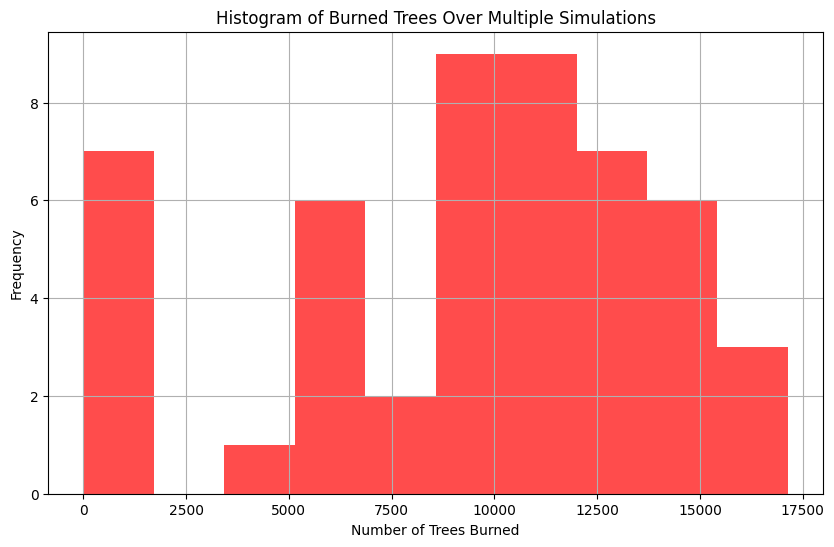

In [32]:
num_runs = 50
steps_per_run = 100
results1 = run_simulation_multiple_times(section_normalized, (-1, 1), 0.5, num_runs, steps_per_run)
plot_histogram(results1)

In [33]:
bootstrap_interval = bootstrap_confidence_interval(results1, num_samples=10000, ci=95)
print(f"Mean: {np.mean(results1)}", )
print(f"95% Confidence Interval: {bootstrap_interval}", )

Mean: 9335.28
95% Confidence Interval: (8012.87, 10626.61)


# Random firebreaks strategy results

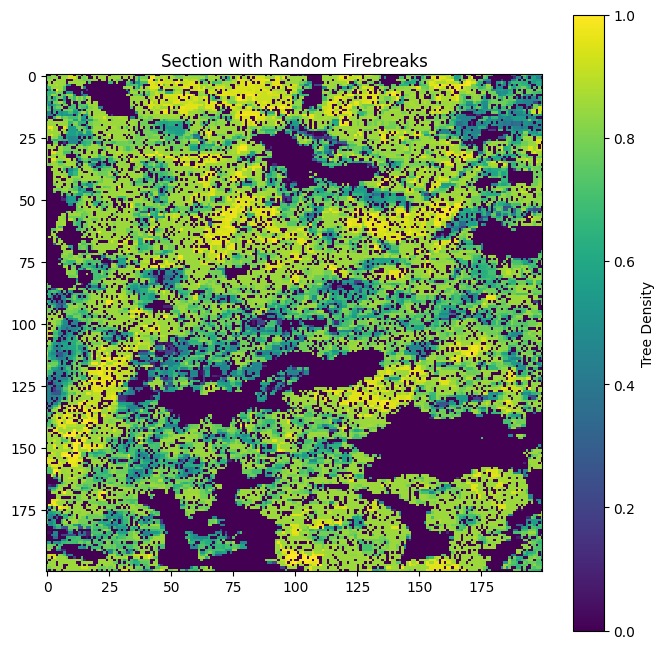

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def create_firebreaks(data, percentage=10):
    """
    Creates random empty cells throughout the grid.
    Percentage is adjustable
    """
    flattened = data.flatten()
    indices = np.random.choice(flattened.size, int(flattened.size * percentage / 100), replace=False)
    flattened[indices] = 0
    return flattened.reshape(data.shape)


# Apply to the map
section_with_firebreaks = create_firebreaks(section_normalized, percentage=20)

# Show the change
plt.figure(figsize=(8, 8))
plt.imshow(section_with_firebreaks, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Tree Density')
plt.title('Section with Random Firebreaks')
plt.show()


In [19]:
#showing one simulation
sim = ForestFireSimulation(section_with_firebreaks, (1,1), 0.5 )  # Wind and strength
animation_html = make_animation(sim, total_frames=100, steps_per_frame=1, interval=100)
animation_html


Fire started at (28, 107)


  0%|          | 0/100 [00:27<?, ?it/s]


<Figure size 1000x1000 with 0 Axes>

Fire started at (76, 111)
Fire started at (12, 35)
Fire started at (81, 92)
Fire started at (124, 162)
Fire started at (35, 47)
Fire started at (155, 117)
Fire started at (87, 194)
Fire started at (85, 13)
Fire started at (12, 160)
Fire started at (140, 53)
Fire started at (82, 141)
Fire started at (151, 61)
Fire started at (45, 159)
Fire started at (123, 88)
Fire started at (124, 21)
Fire started at (98, 170)
Fire started at (181, 15)
Fire started at (93, 134)
Fire started at (66, 153)
Fire started at (135, 77)
Fire started at (15, 135)
Fire started at (185, 154)
Fire started at (113, 151)
Fire started at (89, 59)
Fire started at (172, 150)
Fire started at (14, 94)
Fire started at (72, 133)
Fire started at (134, 32)
Fire started at (120, 23)
Fire started at (8, 7)
Fire started at (101, 138)
Fire started at (172, 78)
Fire started at (161, 162)
Fire started at (65, 87)
Fire started at (16, 44)
Fire started at (138, 105)
Fire started at (55, 40)
Fire started at (8, 74)
Fire started at (1

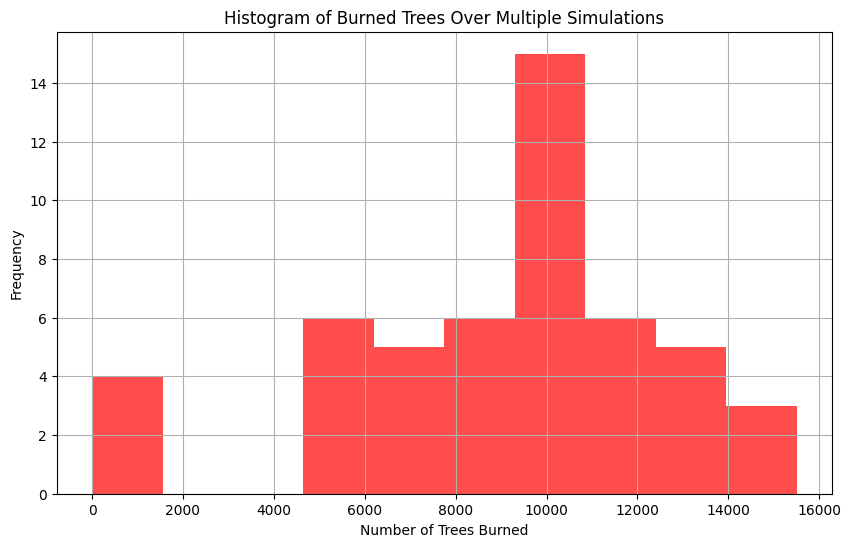

In [34]:
num_runs = 50
steps_per_run = 100
results2 = run_simulation_multiple_times(section_with_firebreaks, (-1, 1), 0.5, num_runs, steps_per_run)
plot_histogram(results2)

In [35]:
bootstrap_interval = bootstrap_confidence_interval(results2, num_samples=10000, ci=95)
print(f"Mean: {np.mean(results2)}", )
print(f"95% Confidence Interval: {bootstrap_interval}", )

Mean: 9074.08
95% Confidence Interval: (8043.72, 10036.44)


# Grid firebreaks strategy results

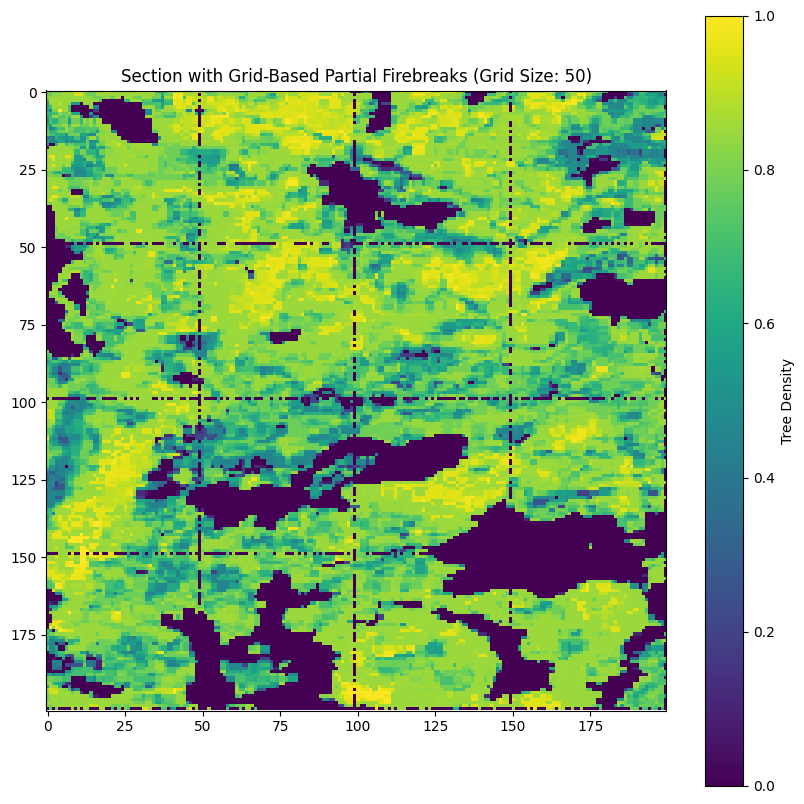

In [21]:


def add_grid_firebreaks(data, grid_size, firebreak_coverage=0.5):
    """
    Divides the area into cubic sections by putting firebreaks horizontally and vertically on specific values.
    It does not create perfect lines for making it more realistic.
    grid_size is adjustable.
    firebreak_coverage is adjustable.
    """
    modified_data = np.copy(data)
    num_rows, num_cols = data.shape

    # specified rows
    for index in range(grid_size - 1, num_rows, grid_size):
        clear_indices = np.random.choice(num_cols, int(num_cols * firebreak_coverage), replace=False)
        modified_data[index, clear_indices] = 0

    # specified columns
    for index in range(grid_size - 1, num_cols, grid_size):
        clear_indices = np.random.choice(num_rows, int(num_rows * firebreak_coverage), replace=False)
        modified_data[clear_indices, index] = 0

    return modified_data

grid_size = 50  #higher values = larger cubes
firebreak_coverage = 0.6  #higher values = more perfectly filled lines

section_with_grid_firebreaks = add_grid_firebreaks(section_normalized, grid_size, firebreak_coverage)

# Show the change
plt.figure(figsize=(10, 10))
plt.imshow(section_with_grid_firebreaks, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Tree Density')
plt.title(f'Section with Grid-Based Partial Firebreaks (Grid Size: {grid_size})')
plt.show()


In [22]:
#showing one simulation
sim = ForestFireSimulation(section_with_grid_firebreaks, (1,1), 0.5 )  # Wind and strength
animation_html = make_animation(sim, total_frames=100, steps_per_frame=1, interval=100)
animation_html

Fire started at (11, 197)


  0%|          | 0/100 [00:29<?, ?it/s]


<Figure size 1000x1000 with 0 Axes>

Fire started at (17, 55)
Fire started at (49, 28)
Fire started at (167, 36)
Fire started at (22, 120)
Fire started at (105, 101)
Fire started at (48, 59)
Fire started at (136, 61)
Fire started at (82, 169)
Fire started at (144, 94)
Fire started at (43, 33)
Fire started at (193, 72)
Fire started at (160, 126)
Fire started at (171, 31)
Fire started at (86, 196)
Fire started at (181, 117)
Fire started at (58, 47)
Fire started at (44, 177)
Fire started at (169, 46)
Fire started at (114, 27)
Fire started at (128, 147)
Fire started at (100, 80)
Fire started at (101, 115)
Fire started at (188, 77)
Fire started at (193, 137)
Fire started at (185, 8)
Fire started at (46, 21)
Fire started at (166, 177)
Fire started at (73, 47)
Fire started at (190, 8)
Fire started at (95, 142)
Fire started at (186, 4)
Fire started at (85, 130)
Fire started at (143, 59)
Fire started at (171, 34)
Fire started at (192, 91)
Fire started at (78, 67)
Fire started at (10, 13)
Fire started at (190, 165)
Fire started at 

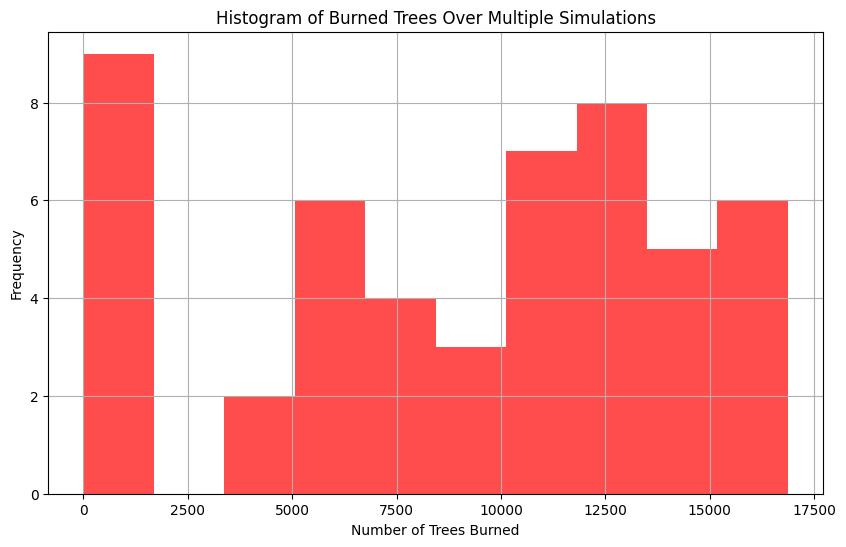

In [23]:
num_runs = 50
steps_per_run = 100
results = run_simulation_multiple_times(section_with_grid_firebreaks, (-1, 1), 0.5, num_runs, steps_per_run)
plot_histogram(results)

In [30]:
bootstrap_interval = bootstrap_confidence_interval(results, num_samples=10000, ci=95)
print(f"Mean: {np.mean(results)}", )
print(f"95% Confidence Interval: {bootstrap_interval}", )


Mean: 8859.92
95% Confidence Interval: (7388.48, 10311.75)
